In [ ]:
import pandas as pd
import numpy as np

Attributes description of every file:
    1. Books
    ISBN: book's unique id
    Book-Title: Title of book
    Book-Author: Author of book
    Publisher: Organization that published book
    Year-Of-Publication: published year
    Image-URL-S: url of book's image small size
    Image-URL-M: url of book's image medium size
    Image-URL-L: url of book's image large size
        
    2. Users
    User-ID: unique id for user
    Location: physicall address of user (city, state, country)
    Age: age of this user
    
    3. Book-Ratings:
    User-ID: id of user who rated
    ISBN: id of book that was rated
    Book-Rating: score that user gives to book (from 1 to 10)

In [ ]:
path = '../input/bookcrossing-dataset/Book reviews/Book reviews/'

If I will load files correctly then shapes of files will be: Books (271379, 8); Book-Ratings (1149780, 3); Users(278858, 3)

In [ ]:
# Load data
books = pd.read_csv(path + 'BX_Books.csv', sep=';')

book_ratings = pd.read_csv(path + 'BX-Book-Ratings.csv', sep=';')

users = pd.read_csv(path + 'BX-Users.csv', sep=';')

In [ ]:
print(books.shape)

print(book_ratings.shape)

print(users.shape)

Check data in files

In [ ]:
books.head()

In [ ]:
book_ratings.head()

In [ ]:
users.head()

In [ ]:
books.info()

In [ ]:
users.info()

In [ ]:
book_ratings.info()

Missing values:
    1. Books: Book author (1 value), Publisher (2 values)
    2. Users: Age (110762 values)
    3. Book-Ratings: None
    

In [ ]:
# Some names of columns look quite fancy to me, so I will rename them

books.rename(columns = {'ISBN': 'book_id',
                        'Book-Title': 'title',
                        'Book-Author': 'author',
                        'Year-Of-Publication': 'published',
                        'Publisher': 'publisher',
                        'Image-URL-S': 'image_small',
                        'Image-URL-M': 'image_medium',
                        'Image-URL-L': 'image_large'
                       }, inplace = True)

users.rename(columns = {'User-ID': 'user_id',
                        'Location': 'location',
                        'Age': 'age',
                       }, inplace = True)

book_ratings.rename(columns = {'User-ID': 'user_id',
                               'ISBN': 'book_id',
                               'Book-Rating': 'score',
                       }, inplace = True)

In [ ]:
# Let's import data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as exp 

Books table

In [ ]:
books.head()

For now, I am not interested in images of books, so I will work with title, author, published, publisher columns.

In [ ]:
# Let's validate published year column
books['published'].agg(['mean', 'min', 'max', 'nunique'])

There empty values for this column, which were replace with 0. Also there books that 'were published' in future. There almost 4000 books out of 270,000 so I will drop them.

In [ ]:
# Get ids of that books, so I can drop them from 2 tables
zero_year = books[(books['published'] == 0) | (books['published'] > 2021)]['book_id'].values

books = books[~books['book_id'].isin(zero_year)].copy()
book_ratings = book_ratings[~book_ratings['book_id'].isin(zero_year)].copy()

In [ ]:
books[['title', 'author', 'published', 'publisher']].nunique()

In [ ]:
by_year_published = books.groupby('published')['book_id'].count()

In [ ]:
byYearPlot = go.Scatter(x=by_year_published.index, y=by_year_published.values, name = "Published books")

layout = go.Layout(
    title = "Books publisher over years",
    xaxis_title = "Years",
    yaxis_title = "Quantity",
)

figure = go.Figure(data = [byYearPlot] , layout = layout)
figure.show() 

With the help of Plotly, you can easily zoom in, or zoom out, by selecting period that you are interested

We can see here, that books in this dataset mostly were published in period of 1980 and 2004.

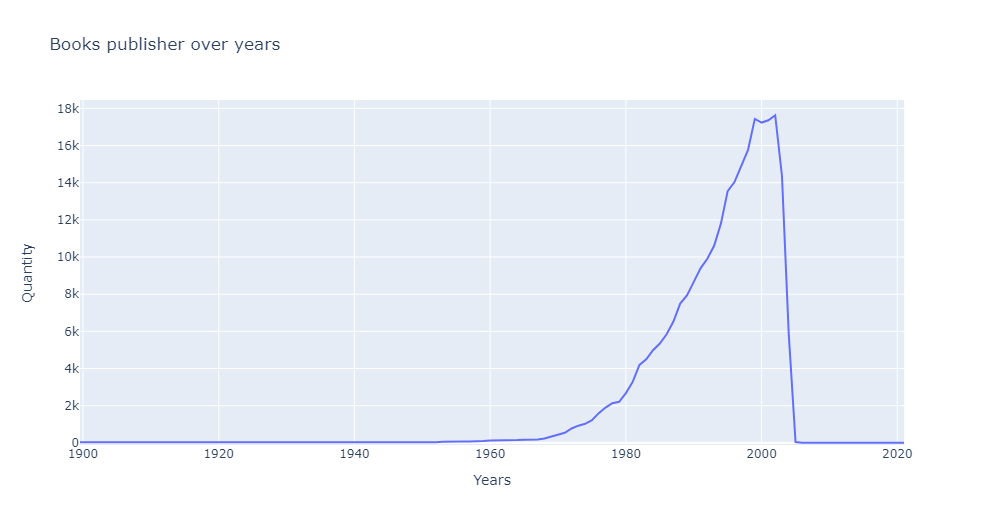

In [ ]:
# Top Authors by Books published
by_author = books.groupby('author')['book_id'].count()

by_author

In [ ]:
# Well, before EDA I should remove this kind of errors.
to_rem = books[books['author'].str.count("^[�?¢²'].*")>0]['book_id'].values

books = books[~books['book_id'].isin(to_rem)].copy()
book_ratings = book_ratings[~book_ratings['book_id'].isin(to_rem)].copy()

In [ ]:
book_ratings.shape

In [ ]:
by_author = books.groupby('author')['book_id'].count()
by_author = by_author.sort_values(ascending = False)
by_author[:10]

In [ ]:
fig = exp.bar(x=by_author.index[:30], y = by_author.values[:30], title = 'Books published by Authors', template = 'ggplot2')

fig.update_xaxes(type='category', tickangle= 45)

fig.show()

As we can't see results of plotly in github, I will paste static images of results.

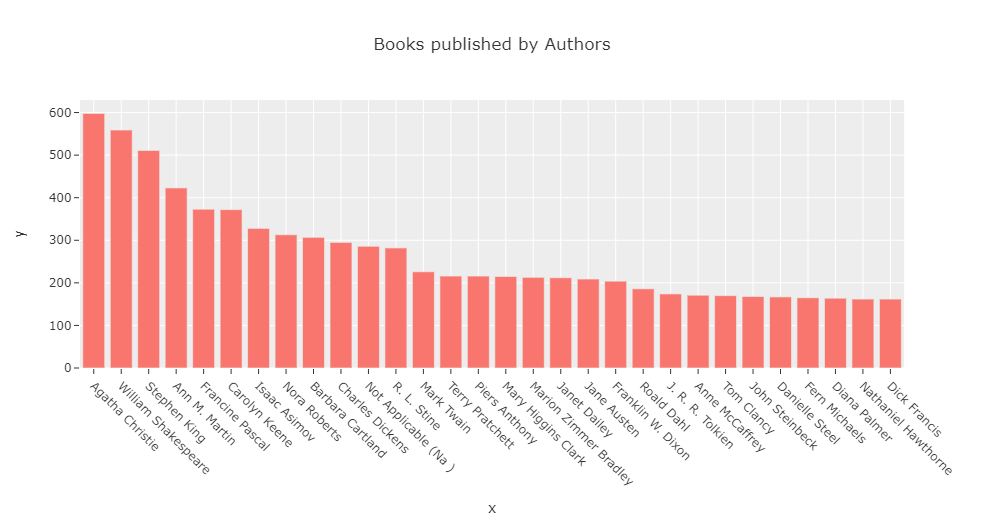

Now, let's try this with publishers

In [ ]:
by_publisher = books.groupby('publisher')['book_id'].count()

by_publisher = by_publisher.sort_values(ascending = False)

In [ ]:
figure = go.Figure(data = [go.Pie(labels = by_publisher.index[:10], 
                                  values = by_publisher.values,
                                  textinfo='label+percent',
                                  title= 'Ten publsihers with most published books.' 
                                 )])

figure.show()

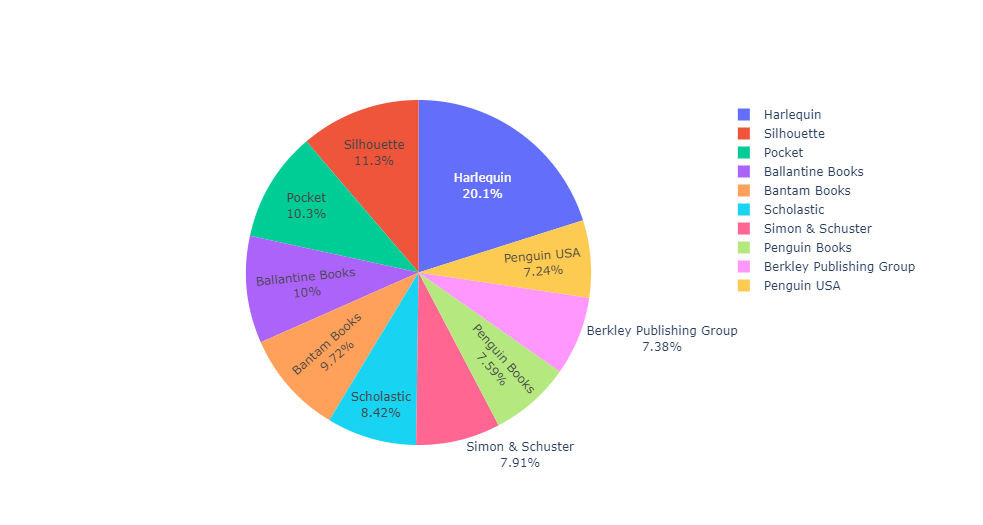

In [ ]:
print(f'Ten most popular publishers published: {sum(by_publisher.values[:10])}, Others: {sum(by_publisher.values[11:])}')

Finally let's play around with book title

In [ ]:
books.tail()

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords.words('english')
print(stopwords.words() [620:680])
# Here I want to split every title of book to words and check whereas this word length greater than 3 or it's not in stop words.
# If everything is fine, then I will add that word into array.

In [ ]:
from collections import Counter
results = Counter()
books['title'].str.lower().str.split().apply(results.update)

In [ ]:
most_common = dict(results.most_common(1000))

to_replace = ['(', ')', '*', '((', '))']
own_stop_words = ['book', 'guide', 'novel']

top_words = {}

for k, v in most_common.items():
    
    for err in to_replace:
        k = k.replace(err, "")
        
    if (len(k) > 3) and (k not in stopwords.words()) and (k not in own_stop_words):
        top_words[k] = v
        

In [ ]:
# top_words, Sort dictionary by values
top_words = dict(sorted(top_words.items(), key=lambda item: item[1])[::-1][:20])

In [ ]:
figure = go.Figure(data = [go.Pie(labels = list(top_words.keys()), 
                                  values = list(top_words.values()),
                                  textinfo='label+percent',
                                  title= 'Twenty most used words in book titles.' 
                                 )])

figure.show()

It looks like at the stage of data collecting, publisher loaded as title also, but other words look pretty fair for me.

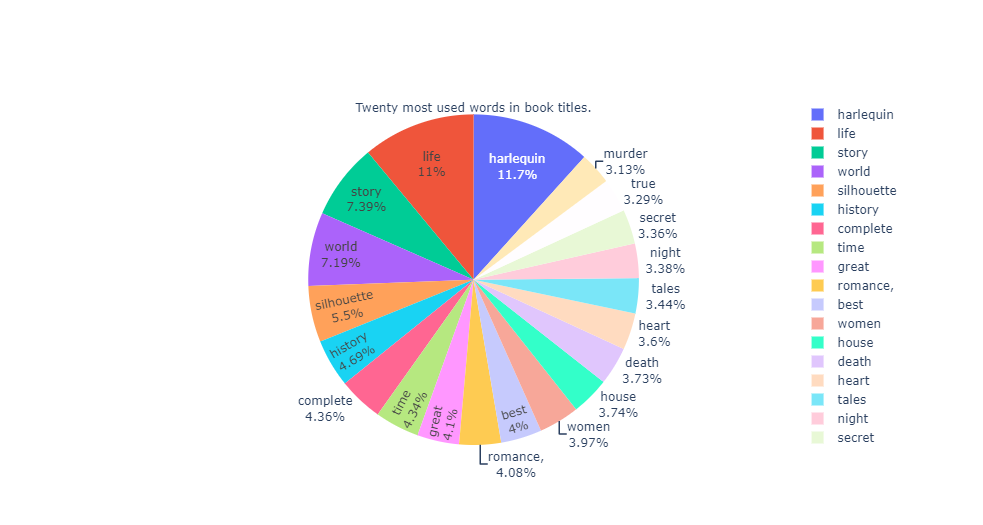

This chart says everything for itself. Before moving from this table, I would like to perform related to authors with most published books for every year in range and e.t.c.

In [ ]:
# As year range I will take from 1980 to 2005. Also due to huge amount of authors I will take to 10 for each year

target = books[(books['published'] > 1979) & (books['published'] < 2005)]
by_authors_over_years = target.groupby(['published', 'author'])['book_id'].count()

In [ ]:
by_authors_over_years = by_authors_over_years.reset_index()

In [ ]:
by_author_over_years_top = pd.DataFrame(columns=['year', 'author', 'book_id'])

for year in range(1980, 2005):
    by_author_over_years_top = pd.DataFrame(np.vstack([by_author_over_years_top, by_authors_over_years[by_authors_over_years['published'] == year].sort_values(by = 'book_id', ascending = False)[:20]]))

In [ ]:
by_author_over_years_top.rename(columns={0: 'published', 1: 'author', 2: 'count'}, inplace=True)
by_author_over_years_top.head()

In [ ]:
fig = exp.bar(by_author_over_years_top, x = 'published',
              y = 'count',
              color = 'author', title="Published books authors by years",
              template = 'ggplot2')
fig.show()

It looks very beautiful for me, but I have another option that may seem to you more understandable. Below static version for github.

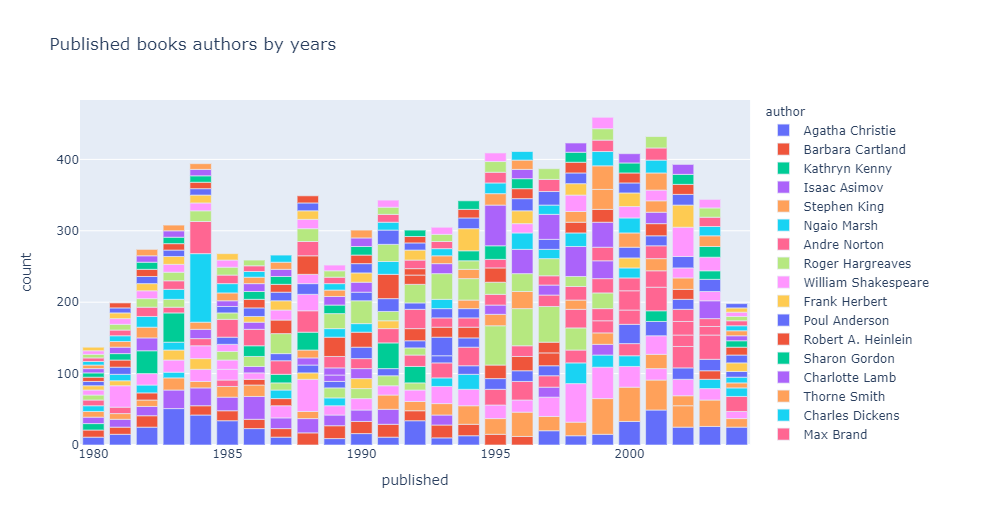

Bar on above is interactive, but it doesn't move or make some actions. In code below, I will try to create racing bar Graph, taking 5 Authors with most published books in respective year. As in previous bar, I will get only books that were published from 1980 up to 2005.

In [ ]:
# Let's import plotly itself + io
import plotly
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# This time I am getting only 5 authors for each year
by_author_over_years_top = pd.DataFrame(columns=['year', 'author', 'book_id'])

for year in range(1980, 2005):
    by_author_over_years_top = pd.DataFrame(np.vstack([by_author_over_years_top, by_authors_over_years[by_authors_over_years['published'] == year].sort_values(by = 'book_id', ascending = False)[:5]]))
    
by_author_over_years_top.rename(columns={0: 'published', 1: 'author', 2: 'count'}, inplace=True)
by_author_over_years_top.head(6)

In [ ]:
fig = go.Figure(
    data = [ # Here all code until updatemenus goes like base point, from where bar started before clicking 'play' button
        go.Bar(
        x = by_author_over_years_top[:5]['count'], y = by_author_over_years_top[:5]['author'], orientation = 'h',
        text = by_author_over_years_top[:5]['count'], textfont = {'size': 18}, textposition = 'inside',  
        insidetextanchor='middle', width = 0.9
        )],
    layout = go.Layout(
        xaxis = dict(range = [0, 40], autorange = False, title=dict(text='Authors with most published books in year', font=dict(size=18))),
        yaxis = dict(range= [-0.5, 5.5], autorange=False,tickfont=dict(size=14)),
        title = dict(text = '5 Authors with most published books in 1984', font=dict(size=28), x=0.5, xanchor='center'),

        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None,
                          {"frame": {"duration": 1500, "redraw": True},
                          "transition": {"duration":400,
                          "easing": "linear"}}]
            )]
        )]
    ),
    frames=[
            go.Frame(
                data=[
                        go.Bar(x= by_author_over_years_top[i:i+5]['count'].values, 
                               y= by_author_over_years_top[i:i+5]['author'].values,
                               orientation='h',
                               text = by_author_over_years_top[i:i+5]['count'].values
                               )
                    ],
                layout=go.Layout(
                        xaxis=dict(range=[0, 40], autorange=False),
                        yaxis=dict(range=[-0.5, 5.5], autorange=False,tickfont=dict(size=14)),
                        title=dict(text='5 Authors with most published books in '+str(by_author_over_years_top.loc[i, 'published']),
                        font=dict(size=28)), 
                    )
            )
        for i in range(0, 125, 5)
    ]
)

pio.show(fig)

Here is static version for Github.

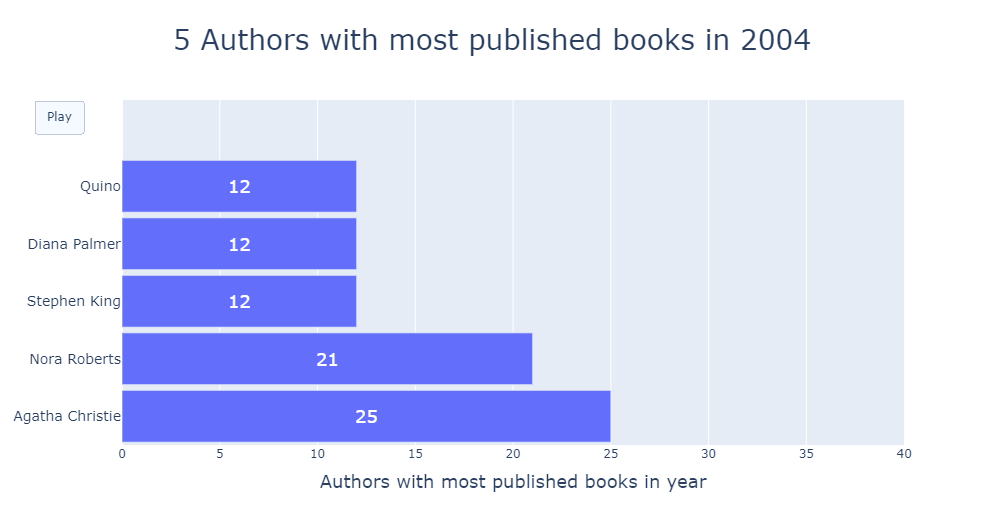

In [ ]:
# Before I move on other files I want to remove NA values from books file
books.isnull().sum()

In [ ]:
to_drop = books.loc[(books['author'].isna()) | (books['publisher'].isna()), 'book_id'].values

books = books[~books['book_id'].isin(to_drop)].copy()

book_ratings = book_ratings[~book_ratings.isin(to_drop)].copy()

EDA on books file finished, Next is users file.

In [ ]:
users.tail()

Let's divide location column to city/region/country columns. I am not sure about region column, but firstly let's check data ;)

In [ ]:
# This code below should easily break location format into pieces,
# but it may happen in some Utopia, we have some values that splitted into 1 or 9 values, let's check that values

#loc_detailed = ['city', 'region', 'country']
#for i in range(3):
#    users[loc_detailed[i]] = users['location'].apply(lambda x: x.split(', ')[i])

In [ ]:
# Checking the outliers in location column
c = 0
for location in users['location']:
    
    splitted = location.split(', ')
    
    length = len(splitted)
    
    if length != 3:
        c+=1 # Number of outliers
        #print(splitted)

In [ ]:
# To check whereas this value is in format I am seeking for
def is_format(value):
    return len(value.split(', ')) == 3

Here we can see 5601 rows are not standard values, so for next steps I will just remove them, but for final result I will try to save as many as possible

In [ ]:
# Removing that outliers
formatted = users[users['location'].apply(lambda x: is_format(x))].copy()

formatted.shape

In [ ]:
users.shape

In [ ]:
# This time it works fine
loc_detailed = ['city', 'region', 'country']
for i in range(3):
    formatted[loc_detailed[i]] = formatted['location'].apply(lambda x: x.split(', ')[i].capitalize())

In [ ]:
formatted.tail()

In [ ]:
# First let's work values by city, region, country and then try to visualize data in World map.
# By Cities
by_city = formatted.groupby('city')['user_id'].count()

In [ ]:
by_city.head()

In [ ]:
# Looks like I should remove errors in this file again.

In [ ]:
formatted = formatted[formatted['city'].apply(lambda x: x.isalnum())].copy()

In [ ]:
by_city = pd.DataFrame(formatted.groupby('city')['user_id'].count())

Well... this sh*t can be done eternal, so let's move on with what we have.

In [ ]:
by_city = by_city.sort_values(by = ['user_id'], ascending = False)[:30]

figure = go.Figure(data = [go.Pie(labels = list(by_city.index), 
                                  values = list(by_city['user_id'].values),
                                  textinfo='label+percent',
                                  title= 'Thirty most popular cities' 
                                 )])

figure.show()

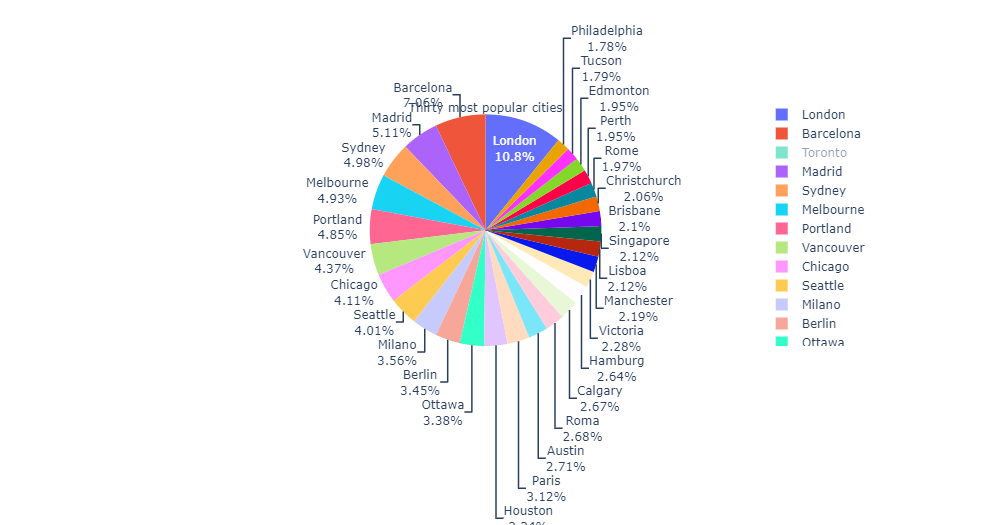

Let's try this pie chart again, but this time with countries

In [ ]:
by_countries = pd.DataFrame(formatted.groupby('country')['user_id'].count())

by_countries = by_countries.sort_values(by = ['user_id'], ascending = False)[:20]


figure = go.Figure(data = [go.Pie(labels = list(by_countries.index), 
                                  values = list(by_countries['user_id'].values),
                                  textinfo='label+percent',
                                  title= 'Thirty most popular countries' 
                                 )])

figure.show()

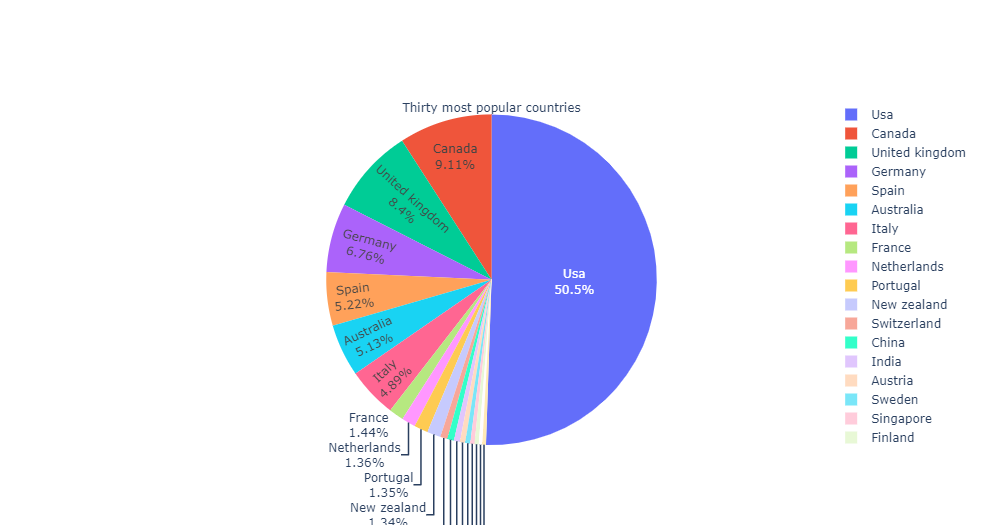

In [ ]:
formatted.groupby('age')['user_id'].count()

Let's remove this data also (I am removing all this outliers just because I've a lot of data, but some cases I might replace it with means or try to fix misspells)

In [ ]:
# Sorry babies and elders
formatted = formatted[(formatted['age'] > 10) & (formatted['age'] < 100)].copy()

In [ ]:
by_age = formatted.groupby('age')['user_id'].count()

In [ ]:
fig = exp.bar(x = by_age.index, y=by_age.values,
             color= by_age.values,
             height=400,
             title = 'Distributions of reviews by age')
fig.show()

Looks like mostly people are aged between 18 and 38. We can also check that with intervals

In [ ]:
formatted['age'].describe()

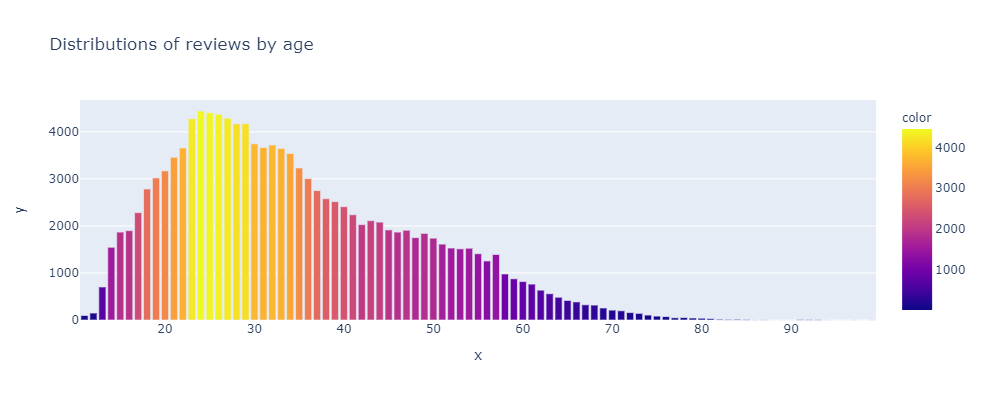

Finally, World Map part

In [ ]:
# This one actually not best practice, I guess I should create smth like function
formatted.loc[formatted['country'] == 'United states', 'country'] = 'United States'
formatted.loc[formatted['country'] == 'Usa', 'country'] = 'United States'
formatted.loc[formatted['country'] == 'United kingdom', 'country'] = 'United Kingdom'
formatted.loc[formatted['country'] == 'New zealand', 'country'] = 'New Zealand'
formatted.loc[formatted['country'] == 'Iran', 'country'] = 'Iran (Islamic Republic of)'
formatted.loc[formatted['country'] == 'South africa', 'country'] = 'South Africa'
formatted.loc[formatted['country'] == 'Czech republic', 'country'] = 'Czech Republic'
formatted.loc[formatted['country'] == 'South korea', 'country'] = 'Korea, Republic of'
formatted.loc[formatted['country'] == 'Vietnam', 'country'] = 'Viet Nam'
formatted.loc[formatted['country'] == 'Costa rica', 'country'] = 'Costa Rica'
formatted.loc[formatted['country'] == 'United arab emirates', 'country'] = 'United Arab Emirates'
formatted.loc[formatted['country'] == 'Saudi arabia', 'country'] = 'Saudi Arabia'
formatted.loc[formatted['country'] == 'Bosnia and herzegovina', 'country'] = 'Bosnia and Herzegovina'
formatted.loc[formatted['country'] == 'England', 'country'] = 'United Kingdom'
formatted.loc[formatted['country'] == 'Scotland', 'country'] = 'United Kingdom'
formatted.loc[formatted['country'] == 'Hong kong', 'country'] = 'Hong Kong'

In [ ]:
import geopandas as gpd

# With the help of gpd, read world map file
world_data = gpd.read_file(r'../input/world-map-files/World_Map.shp')

In [ ]:
formatted['country'] = formatted['country'].apply(lambda x: x.replace('"', ""))

In [ ]:
# Create new dataframe 
by_countries = pd.DataFrame(formatted.groupby('country')['user_id'].count().sort_values(ascending = False))

by_countries = by_countries.reset_index()
by_countries = by_countries.rename(columns = {'user_id': 'count'})

In [ ]:
by_countries = by_countries[(by_countries['country'].isin(world_data['NAME']))].copy()

In [ ]:
# Drop countries that we don't find longitude and latitude

formatted = formatted[formatted['country'].isin(world_data['NAME'])].copy()

In [ ]:
by_countries = by_countries.rename(columns = {'country': 'NAME'})

# merge two dataframes by Name column
comb = world_data.merge(by_countries, on = 'NAME')

In [ ]:
ax = comb.plot(
    column = 'count',
    cmap = 'OrRd',
    figsize = (12, 10),
    legend = True,
    scheme = 'user_defined',
    classification_kwds = {'bins': [10, 100, 500, 1000, 2000, 5000, 10000, 20000]},
    edgecolor = 'black',
    linewidth = 0.4,
    
)
# Remove axes
ax.set_axis_off()

ax.set_title('World map by users in this dataset')

# Move the legend
ax.get_legend().set_bbox_to_anchor((0.18, 0.6))

After some attempts, I decided to download longitude and latitude from another file. There we can also get some useful attributes of country like: income group of this country, subregion, scalerank and e.t.c. I will get them also with lat/long and in next steps try to test hypothesis (e.g. how people from different regions tend to rate books).

In [ ]:
countries = pd.read_csv('../input/country-geo/country_centroids_az8.csv')

In [ ]:
countries.head()

Here I will get income, economy and longitude with latitude.

In [ ]:
countries = countries[['sovereignt' ,'income_grp', 'economy', 'Longitude', 'Latitude']].copy()

Once again, I should change some country names in users table, so two dataframes can be merged successfully

In [ ]:
def rename_country(old, new):
    formatted.loc[formatted['country'] == old, 'country'] = new
    
rename_country('United States', 'United States of America')

In [ ]:
rename_country('Iran (Islamic Republic of)', 'Iran')
rename_country('Viet Nam', 'Vietnam')
rename_country('Korea, Republic of', 'South Korea')
rename_country('Congo', 'Democratic Republic of the Congo')

In [ ]:
formatted = formatted[formatted['country'].isin(countries['sovereignt'].unique())].copy()

In [ ]:
formatted.shape

In [ ]:
countries = countries.rename(columns = {'sovereignt': 'country'})

In [ ]:
# There some duplicates in counties table, so i'll keep last one
countries = countries.drop_duplicates(subset='country', keep="last")

In [ ]:
formatted = pd.merge(formatted, countries, on="country")

formatted.head()

In [ ]:
formatted.shape

In [ ]:
# Let's remove unnecessary columns
formatted.drop(['location', 'city', 'region', 'country'], axis = 1, inplace = True)

In [ ]:
# Finally, I am going to merge users with book reviews table
# For this purpose, first I should remove users from book_reviews who were removed from users table

book_ratings = book_ratings[book_ratings['user_id'].isin(formatted['user_id'].unique())].copy()

In [ ]:
book_ratings.shape

Looks like I removed half of the book ratings table.

In [ ]:
user_reviews = pd.merge(formatted, book_ratings, on="user_id")

In [ ]:
user_reviews.head(3)

In [ ]:
by_income = user_reviews.groupby('income_grp')['score'].mean()

by_income

In [ ]:
fig = exp.bar(x=by_income.index, y = by_income.values, title = 'Average scores by income groups', template = 'ggplot2')

fig.show()

Static version for Github

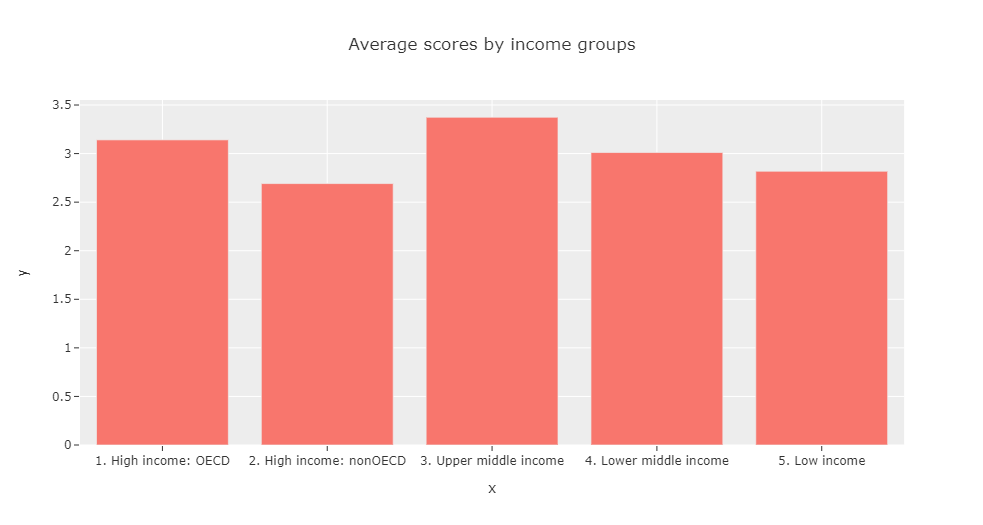

In [ ]:
by_eco = user_reviews.groupby('economy')['score'].mean()

by_eco

In [ ]:
fig = exp.bar(x=by_eco.index, y = by_eco.values, title = 'Average scores by economy', template = 'ggplot2')

fig.show()

Static version for Github

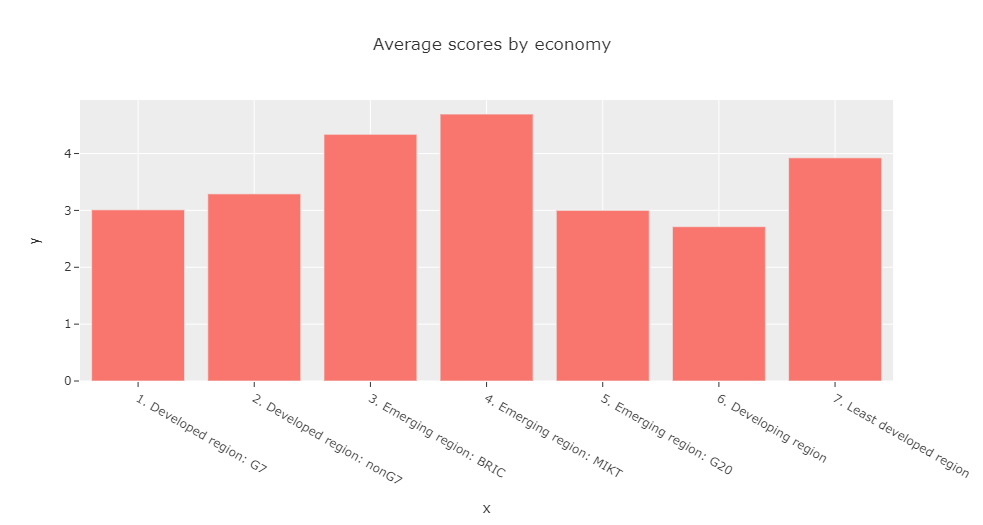

In [ ]:
# Now I can convert income_grp and economy to numerical columns (I will just remove text except leading digits and convert to int)

user_reviews['income_grp'] = user_reviews['income_grp'].apply(lambda x: int(x.split('.')[0]))

In [ ]:
user_reviews['economy'] = user_reviews['economy'].apply(lambda x: int(x.split('.')[0]))

In [ ]:
user_reviews.dtypes

In [ ]:
# Let's check distributions of scores
scores = user_reviews.groupby('score')['user_id'].count()

In [ ]:
fig = exp.bar(x=scores.index, y = scores.values, title = 'Number of reviews to each score', template = 'ggplot2')

fig.show()

It looks like mostly users gave 0 as score. I don't respond validness of this scores, cause even for bad book I would give 1 to 3, but there a lot of zeros.

However, other scores are also enough for us (review scores except 0 look tiny compating to 0 score, but mostly there 10000+ reviews for each of them)

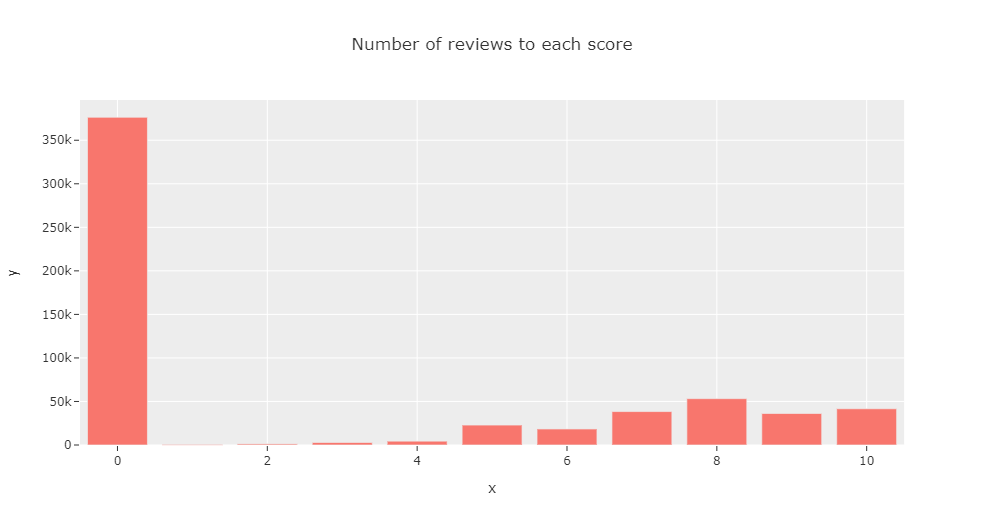